In [ ]:
!pip install pandas scipy scikit-learn cupy-cuda101 livelossplot numba

In [2]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split

from bprH_gpu import bprH

%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv("data/Sobazaar-bprh-cleaned.csv")

In [5]:
# Here we only consider data with View
data = data[~(data.Action == "L")]
data.reset_index(inplace=True, drop=True)
data.drop_duplicates(inplace=True)

In [10]:
# we select user wo have purchased at least 4 items
user_filter = data[data.Action == "P"].groupby("UserID").count().ItemID
data_filtered = data[data.UserID.isin(user_filter[user_filter >= 5].index.tolist())]
# what if we add those users with less 4 purchases into train data?
# TODO

In [11]:
data_without_target = data_filtered[data_filtered.Action != 'P']
data_only_with_target = data_filtered[data_filtered.Action == 'P']

In [12]:
d1, test_data = train_test_split(data_only_with_target,
                                 test_size=0.2,
                                 random_state=20200717
                                 )

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

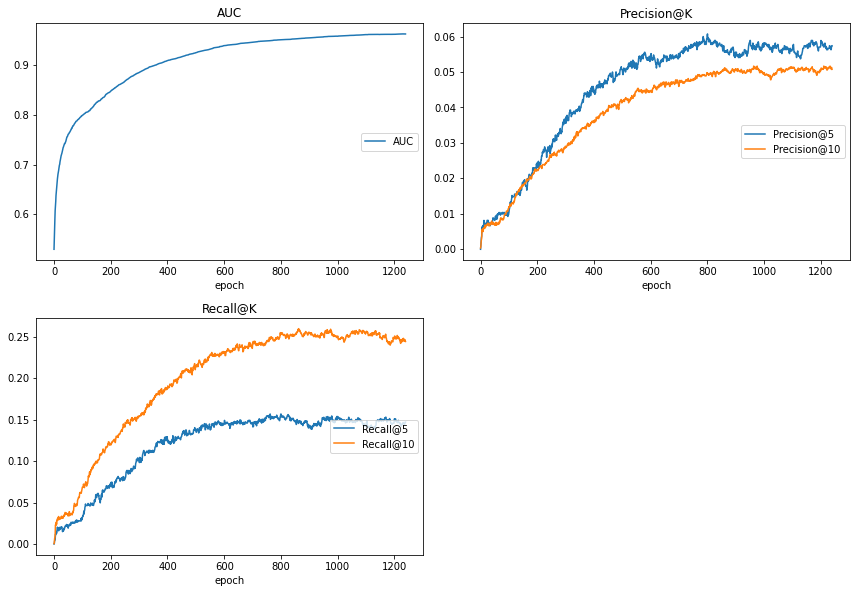

 52%|█████▏    | 744003/1440000 [7:32:16<578:16:02,  2.99s/it, est_changed=0.008614263110672777, len_I=1, len_J=1, len_K=1]

AUC
	AUC              	 (min:    0.530, max:    0.963, cur:    0.963)
Precision@K
	Precision@5      	 (min:    0.000, max:    0.061, cur:    0.057)
	Precision@10     	 (min:    0.000, max:    0.052, cur:    0.051)
Recall@K
	Recall@5         	 (min:    0.000, max:    0.157, cur:    0.147)
	Recall@10        	 (min:    0.001, max:    0.260, cur:    0.244)


 52%|█████▏    | 744121/1440000 [7:32:21<7:03:02, 27.42it/s, est_changed=1.013243362075413, len_I=3, len_J=1, len_K=1]     


KeyboardInterrupt: 

In [14]:
bprh_model = bprH(dim=50,
                  omega=3000,
                  rho=1,
                  lambda_u=0.000005,
                  lambda_v=0.000005,
                  lambda_b=0.000005,
                  gamma=0.1,
                  random_state=20200717,
                  num_iter=180000*8,
                  existed_model_path=None)

bprh_model.fit(X=train_data,
               eval_X=test_data,
               model_saved_path="bprh_soba_0718_filtered5.pkl",
               correlation=True,
               coselection=True,
               plot_metric=True,
               log_metric=True,
               iter_to_log=600,
               iter_to_save=480000)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.test_data,
                                      K=10,
                                      train_data_as_reference_flag=True)
print('Recall: test %.4f.' % r)
print('Precision: test %.4f.' % p)
print('AUC: test %.4f.' % auc)

In [ ]:
scoring_list, p, r, auc = bprh_model.scoring(ground_truth=bprh_model.train_data,
                                      K=10,
                                      train_data_as_reference_flag=False)
print('Recall: train %.4f.' % r)
print('Precision: train %.4f.' % p)
print('AUC: train %.4f.' % auc)

In [15]:
bprh_model.save("bprh_soba_0718_filtered5.pkl_744121")